#### Generating a surface image for 3D Mountain Car

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
screen_width = 600
screen_height = 600
points_resolution = 1000
x = np.linspace(-1.2, 0.6, points_resolution)
y = np.linspace(-1.2, 0.6, points_resolution)
xx, yy = np.meshgrid(x, y)
z = np.sin(3 * xx) + np.sin(3 * yy)

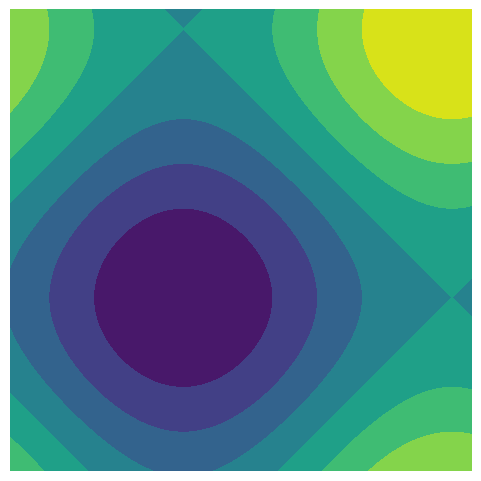

In [12]:
my_dpi = 96
fig = plt.figure(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)

ax2 = fig.add_subplot(1, 1, 1, aspect='equal')
ax2.contourf(x, y, z)
plt.axis('off')
plt.savefig('3d_mountain_car_surf.png', dpi=my_dpi, bbox_inches='tight')

#### Parsing keepaway logs to graph learning curves

In [128]:
from GAME.utils.config import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

config_data = config()

In [129]:
def generate_keepaway_learning_curves(kwy_paths:list, window_size:int=900, alpha:float=0.01, coarse:int=30) -> tuple:
    # init variables
    ep_dur_sum = 0 # Window sum of episode durations
    start = 0
    q = np.zeros(shape = (1, window_size))
    output_X = []
    output_Y = []
    output_eps = []

    # read the first kwy file. There might be more that results from interrupted training
    initial_kwy_file_path = kwy_paths[0]

    # read the first window_size entries
    with open(initial_kwy_file_path, 'r') as f:
        # ignore header
        line = f.readline()
        while line[0] == '#':
            line = f.readline()
        # fill window
        for i in range(len(q[0])):
            if line: # while we still have non-empty lines
                parsed_line = line.split()
                ep_dur = int(parsed_line[3])
                q[0][i] = ep_dur
                ep_dur_sum += q[0][i]
                line = f.readline()
            else:
                raise ValueError("Not enough data to fill window.")

        # read the rest of the data
        i = 0
        ccount = 0
        prev = ep_dur_sum
        while line:
            if ccount % coarse == 0:
                output_X.append(start / 10.0 / 3600)
                output_Y.append(prev / 10.0 / window_size)
                output_eps.append(line.split()[0])
            
            ep_dur_sum -= q[0][i]
            parsed_line = line.split()
            ep_dur = int(parsed_line[3])
            q[0][i] = ep_dur
            ep_dur_sum += q[0][i]
            start += q[0][i]

            prev = (1 - alpha) * prev + alpha * ep_dur_sum
            i = (i + 1) % window_size
            ccount += 1
            line = f.readline()
    
    # continue to parse keepaway files if more are supplied. Appends this data to the previously computed data
    if len(kwy_paths) > 1:
        for kwy_path_idx in range(1, len(kwy_paths)):
            with open(kwy_paths[kwy_path_idx], 'r') as f:
                # ignore header
                line = f.readline()
                while line[0] == '#':
                    line = f.readline()

                # read the rest of the data
                while line:
                    if ccount % coarse == 0:
                        output_X.append(start / 10.0 / 3600)
                        output_Y.append(prev / 10.0 / window_size)
                        output_eps.append(line.split()[0])
                    
                    ep_dur_sum -= q[0][i]
                    parsed_line = line.split()
                    ep_dur = int(parsed_line[3])
                    q[0][i] = ep_dur
                    ep_dur_sum += q[0][i]
                    start += q[0][i]

                    prev = (1 - alpha) * prev + alpha * ep_dur_sum
                    i = (i + 1) % window_size
                    ccount += 1
                    line = f.readline()
    
    # return the parsed kwy data
    return output_X, output_Y, output_eps

In [8]:
kwy_3v2_folder_path = config_data['logs_path'] + 'initial_3v2_training_11052022\\'
first_3v2_train_kwy = kwy_3v2_folder_path + '202211031646-UbuntuXenial.kwy'
second_3v2_train_kwy = kwy_3v2_folder_path + '202211051648-UbuntuXenial.kwy'

kwy_4v3_folder_path = config_data['logs_path'] + 'initial_4v3_training_11052022\\'
first_4v3_train_kwy = kwy_4v3_folder_path + '202211031855-UbuntuXenial.kwy'
second_4v3_train_kwy = kwy_4v3_folder_path + '202211051650-UbuntuXenial.kwy'

kwy_path = second_4v3_train_kwy
kwy_paths = [first_3v2_train_kwy]

In [132]:
kwy_3v2_folder_path = config_data['logs_path'] + 'logs_3v2_10x350eps_learned\\'
experiments = []
for file in os.listdir(kwy_3v2_folder_path):
    if file.endswith('.kwy') and file.split('.')[0] not in experiments:
        experiments.append(file)
    
ep = 0
consolidated_kwy = os.path.join(kwy_3v2_folder_path, 'consolidated_3v2.kwy')
with open(consolidated_kwy, 'w') as f:
    for experiment in experiments:
        with open(os.path.join(kwy_3v2_folder_path, experiment), 'r') as g:
            line = g.readline()
            while line[0] == '#':
                line = g.readline()
            while line:
                split_line = line.split()
                new_line = [str(ep)] + split_line[1:]
                f.write(" ".join(new_line) + "\n")
                ep += 1
                line = g.readline()

kwy_paths = experiments

In [133]:
kwy_3v2_folder_path = config_data['logs_path'] + 'logs_3v2_10x350eps_learned\\'
first_3v2_train_kwy = kwy_3v2_folder_path + 'consolidated_3v2.kwy'

kwy_path = second_4v3_train_kwy
kwy_paths = [first_3v2_train_kwy]

In [134]:
window_size = 900
alpha = 1
coarse = 1
output_X, output_Y, output_eps = generate_keepaway_learning_curves(kwy_paths, window_size, alpha, coarse)

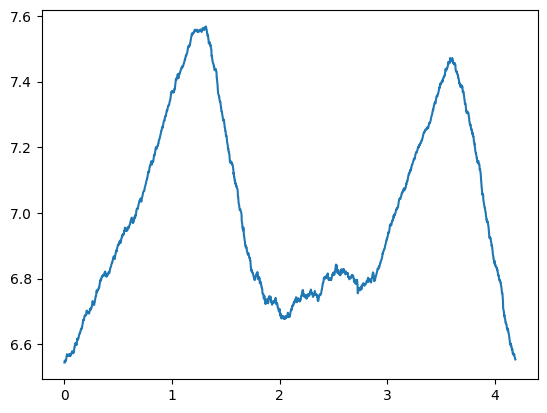

In [135]:
plt.plot(output_X, output_Y)

In [13]:
for x, y in zip(output_eps, output_Y):
    if y > 10:
        print(x, y)
        break

3395 10.012555555555554


#### Generate learning curves for 3D Mountain Car

In [78]:
from GAME.utils.config import config
import pandas as pd
import matplotlib.pyplot as plt

config_data = config()

In [127]:
MC3D_train_folder_path = config_data['output_path'] + '11072022 MC3D No Transfer Consolidated\\'
MC3D_train_filepath = MC3D_train_folder_path + 'eval_3DMC_a0.75_l0.99_e0.01_nt8_cons.csv'

In [128]:
df = pd.read_csv(MC3D_train_filepath, index_col=False)

In [163]:
trials = df.Trial.unique()
trial = 5

df_by_trial = df[df['Trial'] == trial].reset_index(drop = True)

In [164]:
len(df_by_trial)

2010

In [165]:
def generate_MC_learning_curves(training_data:pd.DataFrame, window_size:int=10, alpha:float=0.01, coarse:int=30) -> tuple:
    # init variables
    ep_reward_sum = 0 # Window sum of episode durations
    start = 0
    q = np.zeros(shape = (1, window_size))
    output_X = []
    output_Y = []

    # read the first window_size entries
    i = 0
    for ind, row in training_data.iterrows():
        # fill window
        if ind < window_size:
            ep_reward = row['Reward']
            q[0][i] = ep_reward
            ep_reward_sum += q[0][i]
            i += 1
        else:
            break

    # read the rest of the data
    i = 0
    ccount = 0
    prev = ep_reward_sum
    for ind, row in training_data.iterrows():
        if ind >= window_size:
            if ccount % coarse == 0:
                output_X.append(start)
                output_Y.append(prev / window_size)
            
            ep_reward_sum -= q[0][i]
            ep_reward = row['Reward']
            q[0][i] = ep_reward
            ep_reward_sum += q[0][i]
            # start += q[0][i]
            start = row['Episode']

            prev = (1 - alpha) * prev + alpha * ep_reward_sum
            i = (i + 1) % window_size
            ccount += 1
    
    # return the parsed kwy data
    return output_X, output_Y

In [166]:
output_X, output_Y = generate_MC_learning_curves(df_by_trial)

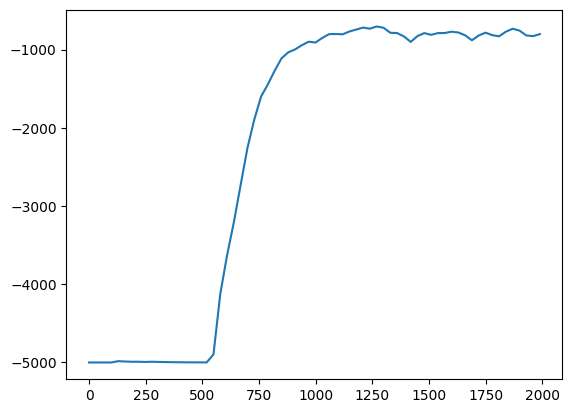

In [167]:
plt.plot(output_X, output_Y)

#### Parsing Keepaway weights files

In [74]:
from GAME.utils.config import config
import numpy as np
import sys
import os

In [15]:
config_data = config()

In [75]:
k3v2_weights_folder = config_data['logs_path'] + '202211031646-UbuntuXenial-3v2-weights//'
k3v2_weights_file = k3v2_weights_folder + 'k1-weights.dat'

k4v3_weights_folder = config_data['logs_path'] + '202211031855-UbuntuXenial-4v3-weights//'
k4v3_weights_file = k3v2_weights_folder + 'k1-weights.dat'

In [119]:
with open(k3v2_weights_file, 'rb') as f:
    rl_mem_size = 1048576
    weights_3v2 = np.fromfile(f, dtype=np.double, count=rl_mem_size)
    
    offset = rl_mem_size * 8
    f.seek(offset, os.SEEK_SET)
    m = np.fromfile(f, dtype=np.int_, count=1)

    offset += 4
    f.seek(offset, os.SEEK_SET)
    safe = np.fromfile(f, dtype=np.intc, count=1)

    offset += 4
    f.seek(offset, os.SEEK_SET)
    calls = np.fromfile(f, dtype=np.int_, count=1)

    offset += 4
    f.seek(offset, os.SEEK_SET)
    clearhits = np.fromfile(f, dtype=np.int_, count=1)

    offset += 4
    f.seek(offset, os.SEEK_SET)
    collisions = np.fromfile(f, dtype=np.int_, count=1)

    offset += 4
    f.seek(offset, os.SEEK_SET)
    data = np.fromfile(f, dtype=np.int_, count=m[0])

In [127]:
count = 0
for d in data:
    if d != -1:
        count += 1
print(count)

11916


In [125]:
count = 0
for w_idx, w in enumerate(weights_3v2):
    if w != 0:
        print(w_idx, w)
        count += 1
count

28 0.09232476433267309
81 0.0441759939975238
320 0.35126007473960585
424 0.43169029046869595
440 0.10286563546511446
507 0.17640214159544945
559 1.1687220028744179
679 0.8778939308645834
737 0.3291793701086722
757 0.4413521727917691
767 0.5566457599423592
850 -1.1972973704520264
1012 0.5979008751364263
1030 0.35122491417203683
1046 -0.1048100743206572
1075 0.5264376770986977
1080 0.39032827574622775
1085 0.9945884477223079
1259 0.06306152876500223
1283 -1.105888532036618
1459 -0.6330883163496646
1626 0.4150891646762665
1799 -0.04246655743931271
1856 -0.4553148544368749
1907 0.4991942241361691
1935 0.7696421677819303
1990 0.3085790052300477
1996 0.14771063323170158
2255 0.08108110666296811
2277 0.19179096909748358
2291 0.07612884696645053
2441 -1.0902688365872868
2453 0.130017897839856
2628 0.7008528549984996
2648 0.27985251643727876
2722 -0.36360648496554343
2754 -0.054896964166170945
2767 -0.8738685439792238
2866 0.6971520920225504
2870 -0.1714568205713668
2906 -0.3269431314462398
303

11575

In [38]:
len(weights_3v2)

1048576